In [1]:
import os

import pandas as pd
from clearml import Task

import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [110]:
def draw_scatter_pair_metrics(df, x_col, y_col, x_col_name=None, y_col_name=None, title=None):

    n_colors = df['dataset'].nunique()

    # Цветовая палитра для датасетов
    palette = sns.color_palette("hls", n_colors)

    # Формы точек для моделей
    markers = ['o', 's', 'D', '^', '<', '>']

    plt.figure(figsize=[5, 5])

    # Создание scatterplot
    sns.scatterplot(
        x=x_col, 
        y=y_col, 
        hue='dataset', 
        style='model',
        data=df,
        palette=palette,
        markers=markers,
        s=100
    )

    if not x_col_name:
        x_col_name = x_col
    
    if not y_col_name:
        y_col_name = y_col

    # Настройка графика
    plt.xlabel(x_col_name)
    plt.ylabel(y_col_name)
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)

    # Диагональная линия
    plt.plot([0, 1], [0, 1], 'k--')

    if title:
        plt.title(title)

    # Легенда
    plt.legend(title='Model / Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    # plt.title('Изменение метрики атаки с дискриминатором и без дискриминатора')
    # # Отображение графика
    # plt.tight_layout()
    plt.show()


# Load 

In [ ]:
# project_name = 'AA_attack_run_GOLDEN'
# #project_name = 'attacks_examples'
# tags_filter = ["__$all", 'Dima', 'Strawberry']
# tags_filter = []

# tags_iteration = [['Dmitry'], ['Sophie']]
# metrics = pd.DataFrame()

# for tags in tags_iteration:
#     tasks = Task.get_tasks(project_name=project_name, tags=tags)
#     # task_example = tasks[-1]
#     print(len(tasks))

#     metrics_ = pd.DataFrame()

#     for task in tasks:
#         task_name = task.name
#         print(task_name) 
#         scalars = task.get_reported_scalars()
#         # experiments[task_name] = scalars
#         #scalars = [scalar for scalar in scalars scalar]

#         df_all_metrics = pd.DataFrame([])

#         for metric_name in scalars:
#             if metric_name[0] == ':':
#                 continue
#             data = scalars[metric_name][metric_name]
#             iters = data['x']
#             values = data['y']
#             df_metric = pd.DataFrame(index=data['x'], columns=[data['name']], data=data['y'])
#             df_all_metrics = df_all_metrics.join(df_metric, how='right')

#         df_all_metrics = df_all_metrics.reset_index()
#         df_all_metrics = df_all_metrics.rename(columns={'index': 'iters'})
#         df_all_metrics['exp_name'] = task_name
#         metrics_ = pd.concat([metrics_, df_all_metrics])
#     metrics = pd.concat([metrics, metrics_])

# metrics.to_csv('../results/attack_metrics_clearml_3.csv')
# metrics

446
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.001
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.01
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.1
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=1
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=10
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=100
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.01__n_steps=50__alpha=0.0001
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.01__n_steps=50__alpha=0.001
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.01__n_steps=50__alpha=0.01
model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,L1,PR,PROB_HID,ROC,ROC_AUC_DISC,ROUGHNESS,ROUGHNESS_NORM,exp_name
0,0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,0.000000,0.965266,0.021848,0.977895,1.000000,0.044127,1.000000,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
1,1,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,1.505000,0.922534,0.022083,0.951579,0.490116,0.045802,1.037978,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
2,2,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,2.775684,0.873987,0.024397,0.918246,0.524857,0.047355,1.073161,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
3,3,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,4.075333,0.826099,0.029835,0.881404,0.587160,0.049146,1.113756,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
4,4,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,5.184747,0.782925,0.041206,0.843860,0.656236,0.051147,1.159093,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,46,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,331.239166,0.464286,1.000000,0.000000,1.000000,0.462208,12.141339,model_S4_100_Coffee_attack_fgsm_attack__eps=0.05__n_steps=50
47,47,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,336.524872,0.464286,1.000000,0.000000,1.000000,0.470248,12.352522,model_S4_100_Coffee_attack_fgsm_attack__eps=0.05__n_steps=50
48,48,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,341.714111,0.464286,1.000000,0.000000,1.000000,0.477875,12.552882,model_S4_100_Coffee_attack_fgsm_attack__eps=0.05__n_steps=50
49,49,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,346.949860,0.464286,1.000000,0.000000,1.000000,0.485686,12.758052,model_S4_100_Coffee_attack_fgsm_attack__eps=0.05__n_steps=50


In [88]:
dataset = 'PowerCons'
model = 'ResidualCNN'

datasets = ['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint']
models = ['ResidualCNN', 'PatchTST'] # ['S4', 'ResidualCNN', 'TST', 'PatchTST', 'RNNA']
prefixes = ['fast_run', 'test']

flag_test = True

# path = f'results/{dataset}/{model}/attack/fgsm_attack_fast_run/model_ResidualCNN_100_PowerCons_attack_fgsm_attack__eps=0.01__n_steps=50.csv'
results = pd.DataFrame()

for dataset in datasets:
    df_dataset = pd.DataFrame()
    for model in models:
        model_data = pd.DataFrame()
        path = f'../results/{dataset}/{model}/attack'

        try:
            experiments = os.listdir(path)
            #experiments = [exp for exp in os.listdir(path) if prefix in exp]
            
            for exp_folder in experiments:
                if exp_folder[0] == '.':
                    continue
                exp_path = os.path.join(path, exp_folder)
                #print(exp_path)
                exp_params = [exp for exp in os.listdir(exp_path) if '.csv' in exp]
                
                exp_data = pd.DataFrame()
                for param_file in exp_params:
                    metric_path = os.path.join(exp_path, param_file)
                    param_df = pd.read_csv(metric_path)
                    #print(metric_path)
                    
                    exp_full_name = param_file.replace('.csv', '')
                    # exp_full_name
                    # for prefix in prefixes:

                    #     print(prefix in exp_name)
                    #     exp_name = exp_name.replace(exp_full_name, '')
                    #     while exp_name[-1] == '_':
                    #         exp_name = exp_name[:-1]
                    param_df['full_exp_name'] = exp_full_name
                    
                    param_df.columns = [col.strip() for col in param_df.columns]

                    exp_data = pd.concat([exp_data, param_df], axis=0)
                
                exp_name = exp_folder
                exp_data['experiment'] = exp_name

                exp_data['model'] = model
                exp_data['dataset'] = dataset

                if len(exp_data.columns) > 22 or flag_test:
                    flag_test = False
                model_data = pd.concat([model_data, exp_data], axis=0)
        except:
            print(path)
        
        #print(len(model_data.columns))
        df_dataset = pd.concat([df_dataset, model_data], axis=0)


    results = pd.concat([results, df_dataset], axis=0)


mask = (results['full_exp_name'].str.contains('pgd')) | (~results['full_exp_name'].str.contains('pgd') & (results['dataset'] == 'PowerCons') & results['model'].isin(['PatchTST', 'ResidualCNN']))
results = results[mask]
results['exp_name'] = results['full_exp_name']

../results/GunPoint/PatchTST/attack


In [89]:
res_check = results[~results['full_exp_name'].str.contains('pgd')]

res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str

res_check['exp_params'] = res_check['exp_params'].str.split('|')
res_check['dataset'].unique()

/tmp/ipykernel_374105/3510677327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
/tmp/ipykernel_374105/3510677327.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_374105/3510677327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name_no_params'], res_c

array(['PowerCons'], dtype=object)

In [90]:
bad_exp = [exp for exp in res_check.full_exp_name.unique() if len(exp) < 30]
res_check[res_check['full_exp_name'].isin(bad_exp)]['exp_name'].unique()

array([], dtype=object)

# Transform

In [91]:
metrics = pd.read_csv('../results/attack_metrics_clearml_3.csv', index_col=0)

na_mask = metrics.T.isna().sum() > 0
metrics = metrics[~na_mask]

metrics.head()

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,L1,PR,PROB_HID,ROC,ROC_AUC_DISC,ROUGHNESS,ROUGHNESS_NORM,exp_name
0,0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,0.000000,0.965266,0.021848,0.977895,1.000000,0.044127,1.000000,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
1,1,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,1.505000,0.922534,0.022083,0.951579,0.490116,0.045802,1.037978,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
2,2,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,2.775684,0.873987,0.024397,0.918246,0.524857,0.047355,1.073161,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
3,3,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,4.075333,0.826099,0.029835,0.881404,0.587160,0.049146,1.113756,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
4,4,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,5.184747,0.782925,0.041206,0.843860,0.656236,0.051147,1.159093,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001


In [92]:
metrics = pd.concat([metrics, results])

In [93]:
metrics['exp_name'] = metrics['exp_name'].str.replace('__', '|')
metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str

metrics['exp_params'] = metrics['exp_params'].str.split('|')
metrics['exp_params'] = metrics['exp_params'].apply(lambda x_list: {x.split('=')[0]:x.split('=')[1] for x in x_list})
metrics = pd.concat([metrics.reset_index(drop=True), pd.json_normalize(metrics['exp_params'])], axis=1)
metrics = metrics.drop(columns=['exp_params'])

metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \
    metrics['exp_name_no_params'].str.split('_', n=4).str
metrics = metrics.drop(columns=['_'])

metrics['attack'] = metrics['attack'].apply(
    lambda x: '_'.join([word for word in x.split('_') if word != 'attack'])
)
metrics['attack_type'] = metrics['attack'].str.split('_').str[0]
metrics['disc_attack'] = metrics['attack'].str.contains("disc")

metrics.head()

/tmp/ipykernel_374105/2431537609.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_374105/2431537609.py:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \


,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,...,exp_name_no_params,eps,n_steps,alpha,eta,delta,seed,attack,attack_type,disc_attack
0,0.0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,...,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack,0.005,50,0.0001,NaN,NaN,100,fgsm_disc,fgsm,True
1,1.0,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,...,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack,0.005,50,0.0001,NaN,NaN,100,fgsm_disc,fgsm,True
2,2.0,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,...,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack,0.005,50,0.0001,NaN,NaN,100,fgsm_disc,fgsm,True
3,3.0,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,...,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack,0.005,50,0.0001,NaN,NaN,100,fgsm_disc,fgsm,True
4,4.0,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,...,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack,0.005,50,0.0001,NaN,NaN,100,fgsm_disc,fgsm,True


In [94]:
hid_col = 'F1'
conc_col = 'F1_DISC'

metrics['EFF'] = 1 - metrics[hid_col]
metrics['CONC'] = 1 - metrics[conc_col]
metrics['F_EFF_CONC'] = 2 * metrics['EFF']  * metrics['CONC'] / (metrics['EFF'] + metrics['CONC'])

In [95]:
mask = (metrics['model'] == 'ResidualCNN') & (metrics['dataset'] == 'PowerCons') # & (metrics['attack'] == 'fgsm')
metrics[mask]['attack'].unique()

array(['fgsm_harmonic', 'fgsm', 'fgsm_disc', 'fgsm_disc_hypercones',
       'pgd_disc', 'pgd'], dtype=object)

# Vizualization

In [96]:
metric_name = 'F_EFF_CONC'

agg_data = metrics.groupby(by=['dataset', 'model', 'attack'], as_index=False).agg({metric_name: max})
agg_data = agg_data.pivot(index=['dataset', 'model'], columns='attack', values=metric_name).reset_index()
# agg_data = agg_data.dropna(subset=['fgsm', 'fgsm_disc'])
agg_data

attack,dataset,model,fgsm,fgsm_disc,fgsm_disc_hypercones,fgsm_harmonic,pgd,pgd_disc
0,Coffee,PatchTST,0.466463,1.000000,NaN,1.000000,NaN,NaN
1,Coffee,RNNA,0.884615,1.000000,NaN,1.000000,NaN,NaN
2,Coffee,ResidualCNN,1.000000,1.000000,NaN,1.000000,NaN,NaN
3,Coffee,S4,0.892537,1.000000,NaN,1.000000,NaN,NaN
4,FreezerRegularTrain,PatchTST,0.644144,0.999649,NaN,0.995091,NaN,NaN
5,FreezerRegularTrain,RNNA,0.400705,0.943598,NaN,NaN,NaN,NaN
6,FreezerRegularTrain,ResidualCNN,0.996297,0.997156,NaN,0.994310,NaN,NaN
7,FreezerRegularTrain,S4,0.353020,0.951026,NaN,NaN,NaN,NaN
8,GunPoint,PatchTST,0.524491,0.802195,NaN,0.767375,NaN,NaN
9,GunPoint,RNNA,0.486486,0.512798,NaN,0.459635,NaN,NaN


/tmp/ipykernel_374105/1096806494.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


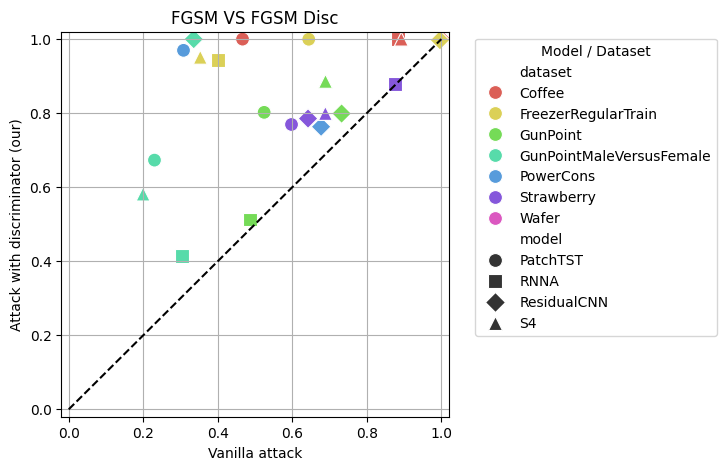

In [111]:
draw_scatter_pair_metrics(agg_data, 'fgsm', 'fgsm_disc', x_col_name='Vanilla attack', y_col_name='Attack with discriminator (our)', title='FGSM VS FGSM Disc')

/tmp/ipykernel_374105/1096806494.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


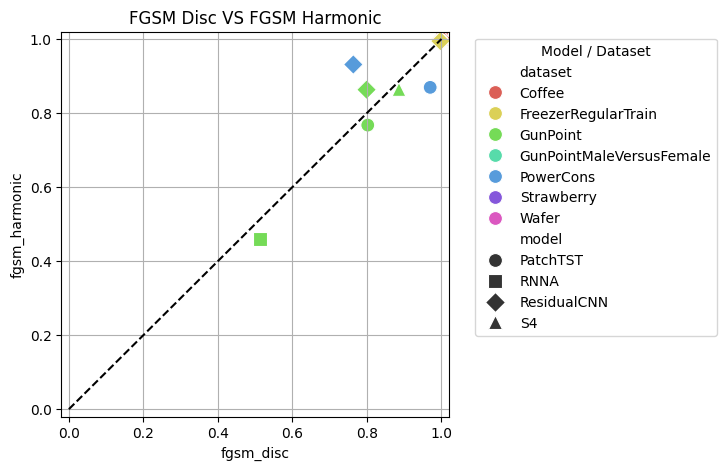

In [112]:
draw_scatter_pair_metrics(agg_data, 'fgsm_disc', 'fgsm_harmonic', title='FGSM Disc VS FGSM Harmonic')

/tmp/ipykernel_374105/1096806494.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


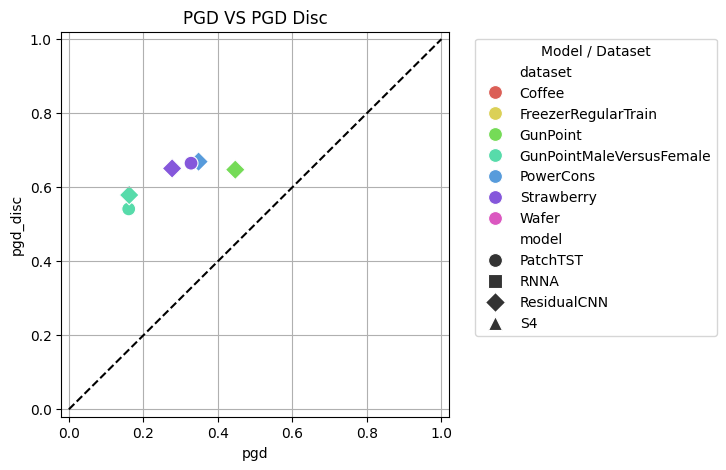

In [113]:
draw_scatter_pair_metrics(agg_data, 'pgd', 'pgd_disc', title='PGD VS PGD Disc')

In [115]:
metric_name = 'F_EFF_CONC'

agg_data = metrics.groupby(by=['dataset', 'model', 'attack'], as_index=False).agg({'EFF': 'max', 'CONC': 'max'})
# agg_data = agg_data.pivot(index=['dataset', 'model'], columns='attack', values=metric_name).reset_index()
# agg_data = agg_data.dropna(subset=['fgsm', 'fgsm_disc'])
agg_data

,dataset,model,attack,EFF,CONC
0,Coffee,PatchTST,fgsm,1.000000,1.0
1,Coffee,PatchTST,fgsm_disc,1.000000,1.0
2,Coffee,PatchTST,fgsm_harmonic,1.000000,1.0
3,Coffee,RNNA,fgsm,1.000000,1.0
4,Coffee,RNNA,fgsm_disc,1.000000,1.0
...,...,...,...,...,...
66,Strawberry,ResidualCNN,pgd,1.000000,1.0
67,Strawberry,ResidualCNN,pgd_disc,1.000000,1.0
68,Strawberry,S4,fgsm,0.778846,1.0
69,Strawberry,S4,fgsm_disc,0.927083,1.0


<AxesSubplot:xlabel='CONC', ylabel='EFF'>

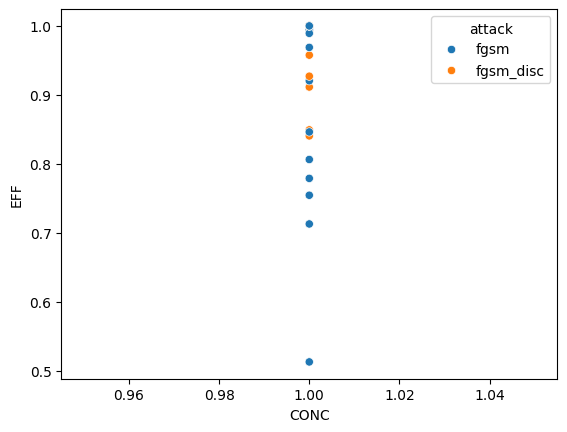

In [117]:
attacks_to_save = ['fgsm', 'fgsm_disc']

df = agg_data[agg_data['attack'].isin(attacks_to_save)]
sns.scatterplot(df, x='CONC', y='EFF', hue='attack')